In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py

--2024-06-06 12:12:51--  https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3832 (3.7K) [text/plain]
Saving to: ‘minsearch.py’

minsearch.py        100%[===================>]   3.74K  --.-KB/s    in 0s      

2024-06-06 12:12:51 (32.2 MB/s) - ‘minsearch.py’ saved [3832/3832]



In [2]:
import minsearch

In [3]:
import json

In [4]:
with open('documents.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

In [9]:
len(docs_raw)

3

In [5]:
documents = []

for course_dict in docs_raw:
    for doc in course_dict['documents']:
        doc['course'] = course_dict['course']
        documents.append(doc)

In [10]:
len(documents)

948

In [11]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

In [12]:
index = minsearch.Index(
    text_fields=["question", "text", "section"],
    keyword_fields=["course"]
)

SELECT * WHERE course = 'data-engineering-zoomcamp';

In [13]:
q = 'the course has already started, can I still enroll?'

In [14]:
index.fit(documents)

### search the question in the indexed questions

In [19]:
boost = {'question': 3.0, 'section': 0.5}

# question filed is 3 times more important.

top_docs = index.search(
    query=q,
    filter_dict={'course': 'data-engineering-zoomcamp'},
    boost_dict=boost,
    num_results=5)

In [20]:
for doc in top_docs:
    print(doc)
    print('----------')

{'text': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.", 'section': 'General course-related questions', 'question': 'Course - Can I still join the course after the start date?', 'course': 'data-engineering-zoomcamp'}
----------
{'text': 'Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it finishes.\nYou can also continue looking at the homeworks and continue preparing for the next cohort. I guess you can also start working on your final capstone project.', 'section': 'General course-related questions', 'question': 'Course - Can I follow the course after it finishes?', 'course': 'data-engineering-zoomcamp'}
----------
{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Ja

### Try LLM

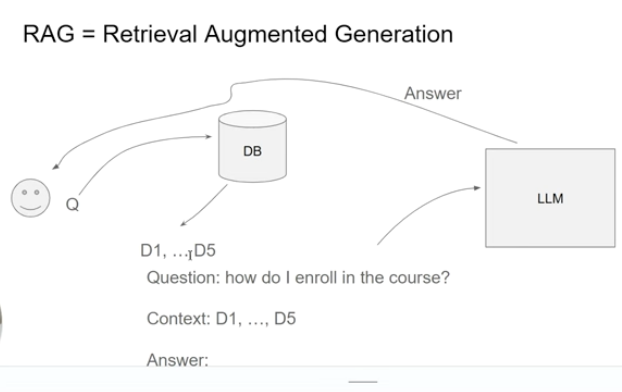

In [24]:
from IPython.display import Image
Image(filename='RAG.png') 

In [9]:
from openai import OpenAI

In [10]:
client = OpenAI()

In [11]:
response = client.chat.completions.create(
    model='gpt-4o',
    messages=[{"role": "user", "content": q}]
)

response.choices[0].message.content

"It's not uncommon for courses to accept enrollments even after they have started, but policies can vary widely depending on the institution or provider offering the course. Here are a few steps you can take to find out if you can still enroll:\n\n1. **Check the Course Platform**: If the course is offered online, visit the course's webpage for information about late enrollment policies.\n\n2. **Contact the Instructor**: Reach out to the course instructor or lead facilitator. They may be willing to make an exception or provide you with the necessary information.\n\n3. **Reach Out to Administrative Offices**: Contact the academic or administrative office responsible for course enrollments. This might be the registrar's office, student services, or a similar department.\n\n4. **Review Deadlines and Policies**: Look for any publicly available documentation outlining the deadlines and policies regarding late enrollments.\n\n5. **Consider Catching Up**: Be prepared to quickly catch up on any

In [12]:
def search(query):
    boost = {'question': 3.0, 'section': 0.5}

    results = index.search(
        query=query,
        filter_dict={'course': 'data-engineering-zoomcamp'},
        boost_dict=boost,
        num_results=5
    )

    return results

In [13]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [14]:
def llm(prompt):
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [15]:
query = 'how do I run kafka?'

def rag(query):
    search_results = search(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [16]:
rag(query)

"To run Kafka, follow the relevant instructions based on your use case:\n\n### For Java:\nNavigate to your project directory and use the following command in the terminal to run a Kafka producer/consumer/KStreams, etc.:\n```shell\njava -cp build/libs/<jar_name>-1.0-SNAPSHOT.jar:out src/main/java/org/example/JsonProducer.java\n```\nReplace `<jar_name>` with the actual name of your JAR file.\n\n### For Python:\nIf you're running Python Kafka, ensure you have your virtual environment set up and activate it. Here’s how you can do it:\n\n1. **Create a virtual environment and install required packages (run only once):**\n    ```shell\n    python -m venv env\n    source env/bin/activate\n    pip install -r ../requirements.txt\n    ```\n\n2. **Activate the virtual environment (run this every time you need it):**\n    ```shell\n    source env/bin/activate\n    ```\n\n3. **Deactivate the virtual environment when done:**\n    ```shell\n    deactivate\n    ```\n\nNote: On Windows, the activation c

In [17]:
rag('the course has already started, can I still enroll?')

'Yes, you can still enroll in the course even after it has started. You are eligible to submit homework assignments, but please be mindful of the deadlines for the final projects to ensure you complete everything on time.'

In [18]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

In [20]:
from elasticsearch import Elasticsearch

In [21]:
es_client = Elasticsearch('http://localhost:9200') 

In [23]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} 
        }
    }
}

index_name = "course-questions"

es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [24]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

In [25]:
from tqdm.auto import tqdm

/usr/local/python/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

100%|██████████████████████████████████| 948/948 [00:28<00:00, 33.07it/s]


In [36]:
query = 'I just disovered the course. Can I still join it?'

In [42]:
def elastic_search(query):
    search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^3", "text", "section"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": "data-engineering-zoomcamp"
                    }
                }
            }
        }
    }

    response = es_client.search(index=index_name, body=search_query)
    
    result_docs = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])
    
    return result_docs

In [44]:
def rag(query):
    search_results = elastic_search(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [45]:
rag(query)

'Yes, you can still join the course even if you discovered it after the start date. You are eligible to submit the homeworks, but be mindful of the deadlines for turning in the final projects. So make sure not to leave everything for the last minute.'